In [1]:
import pylab
import h5py
import math
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform.waveform_modes import get_td_waveform_modes
from pycbc import types, fft, waveform
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm#
from matplotlib.colors import ListedColormap

import matplotlib as mpl

 
from matplotlib import gridspec
from matplotlib import ticker

import matplotlib.pyplot as plt

In [2]:
# Eq. (4.17a, 4.17b), Pg. 18, Moore et al (2016)

def epsilon(xi, eta):
    return(( 1 + ( ( -2833/2016 + 197/72 * eta ) * ( xi )**( 2/3 ) + 
                  ( -377/144 * np.pi * xi + ( ( 77006005/24385536 + ( -1143767/145152 * eta + 
 	 43807/10368 * ( eta )**( 2 ) ) ) * ( xi )**( 4/3 ) + ( np.pi * ( 9901567/1451520 + 
 	 -202589/362880 * eta ) * ( xi )**( 5/3 ) + ( xi )**( 2 ) * ( -33320661414619/386266890240 + 
 	 ( 3317/252 * EulerGamma + ( 180721/41472 * ( np.pi )**( 2 ) + ( ( 161339510737/8778792960 + 
 	 3977/2304 * ( np.pi )**( 2 ) ) * eta + ( -359037739/20901888 * ( eta )**( 2 ) + 
      ( 10647791/2239488 * ( eta )**( 3 ) + ( -87419/3780 * np.log( 2 ) + 
 	 ( 26001/1120 * np.log( 3 ) + 3317/504 * np.log( 16 * ( xi )**( 2/3 ) ) ) ) ) ) ) ) ) ) ) ) ) ) ))

In [3]:
# "Hinder+ modified all 20 simulations SEOBNRv4 model, full frequency range --Feb 16
g=open('/home/pratul/Downloads/Project/Analytical fits/New results/New_tshift_H+modified_20hyb_Feb16.txt',"r") 

lines=g.readlines() 
A=[] 
for x in lines: 
    A.append(float(x.split()[1])) 
g.close()

def tshift_Hinsp(q,e,l): 
    return A[0] + A[1]*q + A[2]*q**2 + A[3]*e + A[4]*e**2 + A[5]*e*q + A[6]*(e**2)*q + A[7]*(e)*math.cos(l + A[8]) + A[9]*(e**1)*(q**1)*math.cos(e*l + A[10]) + A[11]*(e**2)*math.cos(l + A[12])

g=open('/home/pratul/Downloads/Project/Analytical fits/New results/New_tamp_H+modified_20hyb_Feb16.txt',"r") 

lines=g.readlines() 
B=[] 
for x in lines: 
    B.append(float(x.split()[1])) 
g.close()

def tamp_Hinsp(eta,e,l): 
    return B[0] + B[1]*eta + B[2]*eta**2 + B[3]*e + B[4]*e**2 + B[5]*e*eta + B[6]*(e**2)*eta + B[7]*e*math.cos(l + B[8]) + B[9]*(e**1)*(eta**1)*math.cos(l + B[10]) + B[11]*(e**2)*math.cos(e*l + B[12])

g=open('/home/pratul/Downloads/Project/Analytical fits/New results/New_tfreq_H+modified_20hyb_Feb16.txt',"r") 

lines=g.readlines() 
C=[] 
for x in lines: 
    C.append(float(x.split()[1])) 
g.close()

def tfreq_Hinsp(eta,e,l): 
    return C[0] + C[1]*eta + C[2]*eta**2 + C[3]*e + C[4]*e**2 + C[5]*e*eta + C[6]*(e**2)*eta + C[7]*e*eta*math.cos(l + C[8]) + C[9]*(e)*math.cos(l + C[10]) + C[11]*(e**2)*math.cos(e*l + C[12])

In [4]:
def sph_harmonics(inc,ell):
    L=ell
    #inc = 10
    theta = inc
    for l in range(L,L+1):

        for m in range(-l,l+1):
            dlm = 0;
            k1 = max([0, m-2]);
            k2 = min([l+m, l-2]);

            #if(m==l or m==l-1):
            for k in range(k1,k2+1):
                A = []; B = []; cosTerm = []; sinTerm = []; dlmTmp = [];

                A = (-1)**k*math.sqrt(math.factorial(l+m)*math.factorial(l-m)*math.factorial(l+2)*math.factorial(l-2));
                B = math.factorial(k)*math.factorial(k-m+2)*math.factorial(l+m-k)*math.factorial(l-k-2);

                cosTerm = pow(math.cos(theta/2), 2*l+m-2*k-2);
                sinTerm = pow(math.sin(theta/2), 2*k-m+2);

                dlmTmp = (A/B)*cosTerm*sinTerm;
                dlm = dlm+dlmTmp

            Ylm = math.sqrt((2*l+1)/(4*math.pi))*dlm
            #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
            if m==ell:
                #globals()['sph' + str(l) + str(m)] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphlm = Ylm
            elif m==-ell:
                #globals()['sph' + str(l) + '_' + str(abs(m))] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphl_m = Ylm
            else:
                continue
    return sphlm, sphl_m

In [5]:
def xi(x):
    return x**(3/2)

def xconv(f,M):
    return (PI*M*MTSUN_SI*f)**(2/3)  #22 mode conversion

def fconv(x,M):
    return x**(3/2)/(PI*M*MTSUN_SI)  #22 mode conversion


In [6]:
  
hfile = ['/home/pratul/Downloads/Project/New hybrids/Ebersold/1364_EccTD_Ebersold_HM_hyb.h5']    
   
def MODEL(m,q0,e0,l0,fmin,angle,d,delta_t,el,em):
    
    
    for i in range(0,len(hfile)):
        hyb_name = hfile[i][0:4]
        f = h5py.File(hfile[i],'r')
        data = f['l'+str(el)+'_m'+str(em)]
        tVec = real(data[0:,0])
        h22pVec = real(data[0:,1])
        h22cVec = real(data[0:,2])
        mode2polfac=4*(5/(64*np.pi))**(1/2)
        hpVec=h22pVec
        hcVec=h22cVec

        tVec = tVec - tVec[np.argmax(abs(hpVec + 1j*hcVec))]
        M=m
        q=q0
        M1 = q*M/(1+q)
        M2 = M/(1+q)
        eta = q/(1+q)**2

        M_SI=M*MSUN_SI
        D_SI=(10**(6))*PC_SI
        tVec=tVec*M*MTSUN_SI
        hpVec=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
        hcVec=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
    
    
        tVec = tVec - tVec[np.argmax(abs(hpVec + 1j*hcVec))]

        delta_t = delta_t_NR = np.abs(np.mean((np.diff(tVec))))

        fref = 0.075**(3/2) /MTSUN_SI/ PI/M
        #fmin = 0.045**(3/2) /MTSUN_SI/ PI/M 
        xmin = xconv(fmin,30)
        fmin = fconv(xmin,M)


        hp, hc = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, eccentricity=e0)
        sp, sc = get_td_waveform(approximant='SEOBNRv4', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin)
        
        
        
        #NR
        simulation = '/home/pratul/Downloads/Project/NR_data/1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5'
        sims = simulation.split('_')[0]
        lp = el #modes
        mp = em
        tref = 640  # Varies depending on simulations
        mode = 'l'+str(lp)+'_m'+str(mp)
        with h5py.File(simulation, 'r') as hdf:
            temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
            test=np.array(temp)

        x1=test[:,0]
        y1=test[:,1]    
        z1=test[:,2]


        plotband=np.where(x1>=tref)
        x1=x1[plotband]
        x1=x1-x1[np.argmax(abs(y1))]
        y1=y1[plotband]    
        z1=z1[plotband]
        NRAmp = abs(y1-1j*z1)

        tot=y1-1j*z1
        amp=abs(tot)
        ph=np.angle(tot)
        phase_NR=np.unwrap(ph)
        w=np.absolute(diff(phase_NR)/diff(x1))
        phi0=phase_NR[0]

        
        
        
        "time shift"
        "Hinder+ inspired"
        
        tshift = -tshift_Hinsp(q0,e0,l0)*M*MTSUN_SI                  #(Analytical Fit)
        #print(tshift_Hinsp(3,0.142,0.665))
        #tshift = -104.99999999999976 *M*MTSUN_SI         #0               #(Numerical Fit)
        
        #print('tshift=',tshift/(M*MTSUN_SI))
        
        
        
        tmin = max(tVec[0],hp.sample_times[0]-tshift,sp.sample_times[0])

        #alternate
        plotband = np.where(tVec>=tmin)[0][0]
        hpVec = hpVec[plotband:]
        hcVec = hcVec[plotband:]
        tVec = tVec[plotband:]


        h22Hyb = hpVec + 1j*hcVec
        tVec = tVec - tVec[np.argmax(abs(h22Hyb))]
        phaseHyb = -np.unwrap(np.angle(h22Hyb)*2)/2
        omegaHyb = (M*MTSUN_SI/delta_t)*(np.gradient(phaseHyb))


        #circular IMR
        sp_intrp = interp1d(sp.sample_times, sp, kind='cubic',fill_value='extrapolate')
        sc_intrp = interp1d(sp.sample_times, sc, kind='cubic',fill_value='extrapolate')
        tImr_intrp=np.arange(tmin, sp.sample_times[-1], delta_t)
        sp_intrp = sp_intrp(tImr_intrp)
        sc_intrp = sc_intrp(tImr_intrp)
        tImr = tImr_intrp
        hpImr = sp_intrp
        hcImr = sc_intrp
        h22Imr = hpImr + 1j*hcImr


        

        # interpolation EccentricTD
        
        hp_intrp = interp1d(hp.sample_times-tshift, hp, kind='cubic',fill_value='extrapolate')
        hc_intrp = interp1d(hc.sample_times-tshift, hc, kind='cubic',fill_value='extrapolate')
        # new (unifrom) sampling rate (for interpolation and further processing)
        tEcc_intrp=np.arange(tmin, hp.sample_times[-1]-tshift, delta_t)
        hp_intrp = hp_intrp(tEcc_intrp)
        hc_intrp = hc_intrp(tEcc_intrp)
        tEcc = tEcc_intrp
        hpEcc = hp_intrp
        hcEcc = hc_intrp
        h22Ecc = hpEcc + 1j*hcEcc

        phaseEcc = np.unwrap(np.angle(h22Ecc)*2)/2
        phaseImr = abs(np.unwrap(np.angle(h22Imr)*2)/2)

        #######
        dphase = phaseEcc[0] - phaseImr[0]
        hp_new = real(h22Ecc * exp(-1j * dphase))
        hc_new = imag(h22Ecc * exp(-1j * dphase))
        
        
 
        phase_new = np.unwrap(np.angle(hp_new+1j*hc_new)*2)/2

        phaseEcc = phase_new #-phase_new[0]
        h22Ecc_new = hp_new+1j*hc_new

        "Hinder+ inspired"
        arg = np.argmin(abs(tEcc - tamp_Hinsp(eta,e0,l0)*M*MTSUN_SI)) #tamp_Hinsp(eta,e0,l0) for numerical value
        Idxjoin = arg 

        "Hinder+ inspired"
        t_amp = tamp_Hinsp(eta,e0,l0) - 500                       #(Analytical Fit)
        #t_amp = -29.945782149475438- 500           #-30.13117213098541               #(Numerical Fit)
        
        idxstr = np.argmin(abs(tEcc-t_amp*M*MTSUN_SI))

        "amplitude model"
        amp = []
        count = 0
        length = Idxjoin - idxstr 

        for i in range(idxstr,Idxjoin):
            amp.append(((length-count)*abs(h22Ecc_new[i])+count*abs(h22Imr[i]))/length)
            count = count+1

        t_model = np.concatenate((tEcc[0:Idxjoin],tImr[Idxjoin:len(tImr)]))
        h22amp = np.concatenate((abs(h22Ecc_new[0:idxstr]),amp))
        h22amp_model = np.concatenate((h22amp,abs(h22Imr[Idxjoin:len(h22Imr)])))

        omegaEcc = (M*MTSUN_SI/delta_t)*(np.gradient(phaseEcc))
        omegaImr = (M*MTSUN_SI/delta_t)*(np.gradient(phaseImr))
        

        "Hider+ inspired"
        tjoin0 = tfreq_Hinsp(eta,e0,l0)                                #(Analytical Fit)
        #tjoin0 = -2654.060052127741  #-1950.155187550339 #-6000.155187550339 #-1872.84871595912  #-4277.053132414212                 #(Numerical Fit)
        
        tjoin = tjoin0 * M * MTSUN_SI
        fjoin = np.argmin(abs(tEcc-tjoin)) #+ 500


        "frequency model"
        tstop = min(tEcc[-1],-30*M*MTSUN_SI)
        lst = np.argmin(abs(tEcc-tstop))


        indx = lst - fjoin
        a0 = []
        n = indx - 1 
        k = 0
        for i in range(fjoin,fjoin+indx):   #fjoin - 500
            a0.append(((n-k)*omegaEcc[i]+k*omegaImr[i])/n)
            k = k+1

        f1 = np.concatenate((omegaEcc[0:fjoin],a0))
        frequency_model = np.concatenate((f1,omegaImr[fjoin+indx:len(omegaImr)]))
        phase_f_model = np.cumsum(frequency_model)/(M*MTSUN_SI/delta_t)#+ PI/1.4#PI/2.1#PI/0.1#
        phase_f_model = phase_f_model - phase_f_model[0]+phaseEcc[0]
        print(phaseEcc[0],phase_f_model[0])


        hp_f_model = h22amp_model[:len(phase_f_model)] * np.cos(phase_f_model)
        hc_f_model = h22amp_model[:len(phase_f_model)] * np.sin(phase_f_model)
    
        ht = (mode2polfac/4)*(((1+math.cos(angle))**2 * (hp_f_model - 1j*hc_f_model)) + ((1-math.cos(angle))**2 * (hp_f_model + 1j*hc_f_model)))
        hplus = np.real(ht)
        hcross = np.imag(ht)
    
        hp_model_TS = TimeSeries(hplus,delta_t)
        hc_model_TS = TimeSeries(hcross,delta_t)
    
        return (tVec/(M*MTSUN_SI)), np.real(h22Hyb)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), x1-x1[np.argmax(NRAmp)], y1
    

        # Model-Hybrid Mismatche
        
        #plt.plot(tVec/(M*MTSUN_SI),np.real(h22Hyb)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),color='cyan',linewidth=4,label='Hybrid')
        #plt.plot(t_model/(M*MTSUN_SI), hp_f_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), color='saddlebrown',alpha=1,linestyle='-',linewidth=2,label='model',zorder=3)
        #plt.plot(x1-x1[np.argmax(NRAmp)],y1,label='NR',color='darkblue',linewidth=2)
        #plt.ylabel(r'$h_+$',fontsize=20)
        #plt.xlabel(r'$t/M$',fontsize=20)
        #leg = plt.legend(ncol=2,loc=2,bbox_to_anchor=(0.02,0.96),prop={'size': 16.5})
        #plt.xlim(-3000,100)
        #plt.tight_layout()

In [7]:
def stackup_plots():
    plt.subplots(7,1,figsize=(12,16))
    
    plt.subplot(7, 1, 1)
    
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14) 
    mpl.rcParams['xtick.major.size'] = 12
    mpl.rcParams['xtick.major.width'] = 1
    mpl.rcParams['xtick.minor.size'] = 8
    mpl.rcParams['xtick.minor.width'] = 1
    mpl.rcParams['ytick.major.size'] = 12
    mpl.rcParams['ytick.major.width'] = 1
    mpl.rcParams['ytick.minor.size'] = 8
    mpl.rcParams['ytick.minor.width'] = 1
    plt.locator_params(axis='y',nbins=3)
    plt.tick_params(axis='y',direction='in',right=True)
    plt.tick_params(axis='x',direction='in',top=True)
    
    
    a,b,c,d = MODEL(30,2,0.173,-0.181,16.68,0,1,1./4096,2,2)
    plt.plot(a,b,color='cyan',linewidth=4,label='Hybrid')
    plt.plot(c,d,label='NR',color='darkblue',linewidth=2)
    plt.ylabel(r'Re[$h_{\rm 22}$]',fontsize=15)
    plt.xlim(-4500,100)
    plt.tight_layout()
    plt.axvline(x=-2000,color='grey',linestyle='-',zorder=5,alpha=0.5)
    plt.axvline(x=-1000,color='grey',linestyle='-',zorder=5,alpha=0.5)
    plt.axvspan(-2000,-1000,color='lightgrey',alpha=0.3)
    plt.legend(ncol=2,loc=2,bbox_to_anchor=(0.02,0.96),prop={'size': 16.5},frameon=False)
    
    
    plt.subplot(7, 1, 2)
    
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14) 
    mpl.rcParams['xtick.major.size'] = 12
    mpl.rcParams['xtick.major.width'] = 1
    mpl.rcParams['xtick.minor.size'] = 8
    mpl.rcParams['xtick.minor.width'] = 1
    mpl.rcParams['ytick.major.size'] = 12
    mpl.rcParams['ytick.major.width'] = 1
    mpl.rcParams['ytick.minor.size'] = 8
    mpl.rcParams['ytick.minor.width'] = 1
    plt.locator_params(axis='y',nbins=3)
    plt.tick_params(axis='y',direction='in',right=True)
    plt.tick_params(axis='x',direction='in',top=True)
    
    
    a,b,c,d = MODEL(30,2,0.173,-0.181,16.68,0,1,1./4096,2,1)
    plt.plot(a,b,color='cyan',linewidth=4,label='Hybrid')
    plt.plot(c,d,label='NR',color='darkblue',linewidth=2)
    plt.ylabel(r'Re[$h_{\rm 21}$]',fontsize=15)
    plt.xlim(-4500,100)
    plt.tight_layout()
    plt.axvline(x=-2000,color='grey',linestyle='-',zorder=5,alpha=0.5)
    plt.axvline(x=-1000,color='grey',linestyle='-',zorder=5,alpha=0.5)
    plt.axvspan(-2000,-1000,color='lightgrey',alpha=0.3)
    
    plt.subplot(7, 1, 3)
    
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14) 
    mpl.rcParams['xtick.major.size'] = 12
    mpl.rcParams['xtick.major.width'] = 1
    mpl.rcParams['xtick.minor.size'] = 8
    mpl.rcParams['xtick.minor.width'] = 1
    mpl.rcParams['ytick.major.size'] = 12
    mpl.rcParams['ytick.major.width'] = 1
    mpl.rcParams['ytick.minor.size'] = 8
    mpl.rcParams['ytick.minor.width'] = 1
    plt.locator_params(axis='y',nbins=3)
    plt.tick_params(axis='y',direction='in',right=True)
    plt.tick_params(axis='x',direction='in',top=True)
    
    
    a,b,c,d = MODEL(30,2,0.173,-0.181,16.68,0,1,1./4096,3,3)
    plt.plot(a,b,color='cyan',linewidth=4,label='Hybrid')
    plt.plot(c,d,label='NR',color='darkblue',linewidth=2)
    plt.ylabel(r'Re[$h_{\rm 33}$]',fontsize=15)
    plt.xlim(-4500,100)
    plt.tight_layout()
    plt.axvline(x=-2000,color='grey',linestyle='-',zorder=5,alpha=0.5)
    plt.axvline(x=-1000,color='grey',linestyle='-',zorder=5,alpha=0.5)
    plt.axvspan(-2000,-1000,color='lightgrey',alpha=0.3)
    
    plt.subplot(7, 1, 4)
    
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14) 
    mpl.rcParams['xtick.major.size'] = 12
    mpl.rcParams['xtick.major.width'] = 1
    mpl.rcParams['xtick.minor.size'] = 8
    mpl.rcParams['xtick.minor.width'] = 1
    mpl.rcParams['ytick.major.size'] = 12
    mpl.rcParams['ytick.major.width'] = 1
    mpl.rcParams['ytick.minor.size'] = 8
    mpl.rcParams['ytick.minor.width'] = 1
    plt.locator_params(axis='y',nbins=3)
    plt.tick_params(axis='y',direction='in',right=True)
    plt.tick_params(axis='x',direction='in',top=True)
    
    a,b,c,d = MODEL(30,2,0.173,-0.181,16.68,0,1,1./4096,3,2)
    plt.plot(a,b,color='cyan',linewidth=4,label='Hybrid')
    plt.plot(c,d,label='NR',color='darkblue',linewidth=2)
    plt.ylabel(r'Re[$h_{\rm 32}$]',fontsize=15)
    plt.xlim(-4500,100)
    plt.tight_layout()
    plt.axvline(x=-2000,color='grey',linestyle='-',zorder=5,alpha=0.5)
    plt.axvline(x=-1000,color='grey',linestyle='-',zorder=5,alpha=0.5)
    plt.axvspan(-2000,-1000,color='lightgrey',alpha=0.3)
    
    plt.subplot(7, 1, 5)
    
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14) 
    mpl.rcParams['xtick.major.size'] = 12
    mpl.rcParams['xtick.major.width'] = 1
    mpl.rcParams['xtick.minor.size'] = 8
    mpl.rcParams['xtick.minor.width'] = 1
    mpl.rcParams['ytick.major.size'] = 12
    mpl.rcParams['ytick.major.width'] = 1
    mpl.rcParams['ytick.minor.size'] = 8
    mpl.rcParams['ytick.minor.width'] = 1
    plt.locator_params(axis='y',nbins=3)
    plt.tick_params(axis='y',direction='in',right=True)
    plt.tick_params(axis='x',direction='in',top=True)
    
    
    a,b,c,d = MODEL(30,2,0.173,-0.181,16.68,0,1,1./4096,4,4)
    plt.plot(a,b,color='cyan',linewidth=4,label='Hybrid')
    plt.plot(c,d,label='NR',color='darkblue',linewidth=2)
    plt.ylabel(r'Re[$h_{\rm 44}$]',fontsize=15)
    plt.xlim(-4500,100)
    plt.tight_layout()
    plt.axvline(x=-2000,color='grey',linestyle='-',zorder=5,alpha=0.5)
    plt.axvline(x=-1000,color='grey',linestyle='-',zorder=5,alpha=0.5)
    plt.axvspan(-2000,-1000,color='lightgrey',alpha=0.3)
    
    plt.subplot(7, 1, 6)
    
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14) 
    mpl.rcParams['xtick.major.size'] = 12
    mpl.rcParams['xtick.major.width'] = 1
    mpl.rcParams['xtick.minor.size'] = 8
    mpl.rcParams['xtick.minor.width'] = 1
    mpl.rcParams['ytick.major.size'] = 12
    mpl.rcParams['ytick.major.width'] = 1
    mpl.rcParams['ytick.minor.size'] = 8
    mpl.rcParams['ytick.minor.width'] = 1
    plt.locator_params(axis='y',nbins=3)
    plt.tick_params(axis='y',direction='in',right=True)
    plt.tick_params(axis='x',direction='in',top=True)
    
    
    a,b,c,d = MODEL(30,2,0.173,-0.181,16.68,0,1,1./4096,4,3)
    plt.plot(a,b,color='cyan',linewidth=4,label='Hybrid')
    plt.plot(c,d,label='NR',color='darkblue',linewidth=2)
    plt.ylabel(r'Re[$h_{\rm 43}$]',fontsize=15)
    plt.xlim(-4500,100)
    plt.tight_layout()
    plt.axvline(x=-2000,color='grey',linestyle='-',zorder=5,alpha=0.5)
    plt.axvline(x=-1000,color='grey',linestyle='-',zorder=5,alpha=0.5)
    plt.axvspan(-2000,-1000,color='lightgrey',alpha=0.3)
    
    plt.subplot(7, 1, 7)
    
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14) 
    mpl.rcParams['xtick.major.size'] = 12
    mpl.rcParams['xtick.major.width'] = 1
    mpl.rcParams['xtick.minor.size'] = 8
    mpl.rcParams['xtick.minor.width'] = 1
    mpl.rcParams['ytick.major.size'] = 12
    mpl.rcParams['ytick.major.width'] = 1
    mpl.rcParams['ytick.minor.size'] = 8
    mpl.rcParams['ytick.minor.width'] = 1
    plt.locator_params(axis='y',nbins=3)
    plt.tick_params(axis='y',direction='in',right=True)
    plt.tick_params(axis='x',direction='in',top=True)
    
    
    a,b,c,d = MODEL(30,2,0.173,-0.181,16.68,0,1,1./4096,5,5)
    plt.plot(a,b,color='cyan',linewidth=4,label='Hybrid')
    plt.plot(c,d,label='NR',color='darkblue',linewidth=2)
    plt.ylabel(r'Re[$h_{\rm 55}$]',fontsize=15)
    plt.xlim(-4500,100)
    plt.axvline(x=-2000,color='grey',linestyle='-',zorder=5,alpha=0.5)
    plt.axvline(x=-1000,color='grey',linestyle='-',zorder=5,alpha=0.5)
    plt.axvspan(-2000,-1000,color='lightgrey',alpha=0.3)
    plt.xlabel(r'$t/M$',fontsize=15)

    plt.tight_layout() 
    
    #plt.savefig('/home/pratul/Downloads/Project/Plots_draft/NR_Hyb_1364_stack_plots.pdf',dpi=300)

0.028078074338946133 0.028078074338946133
0.028087027763609454 0.028087027763609454
0.028081006142218666 0.028081006142218666
0.02808016902087035 0.02808016902087035
0.02807720218291293 0.02807720218291293
0.02807951765130287 0.02807951765130287
0.028080836327936842 0.028080836327936842


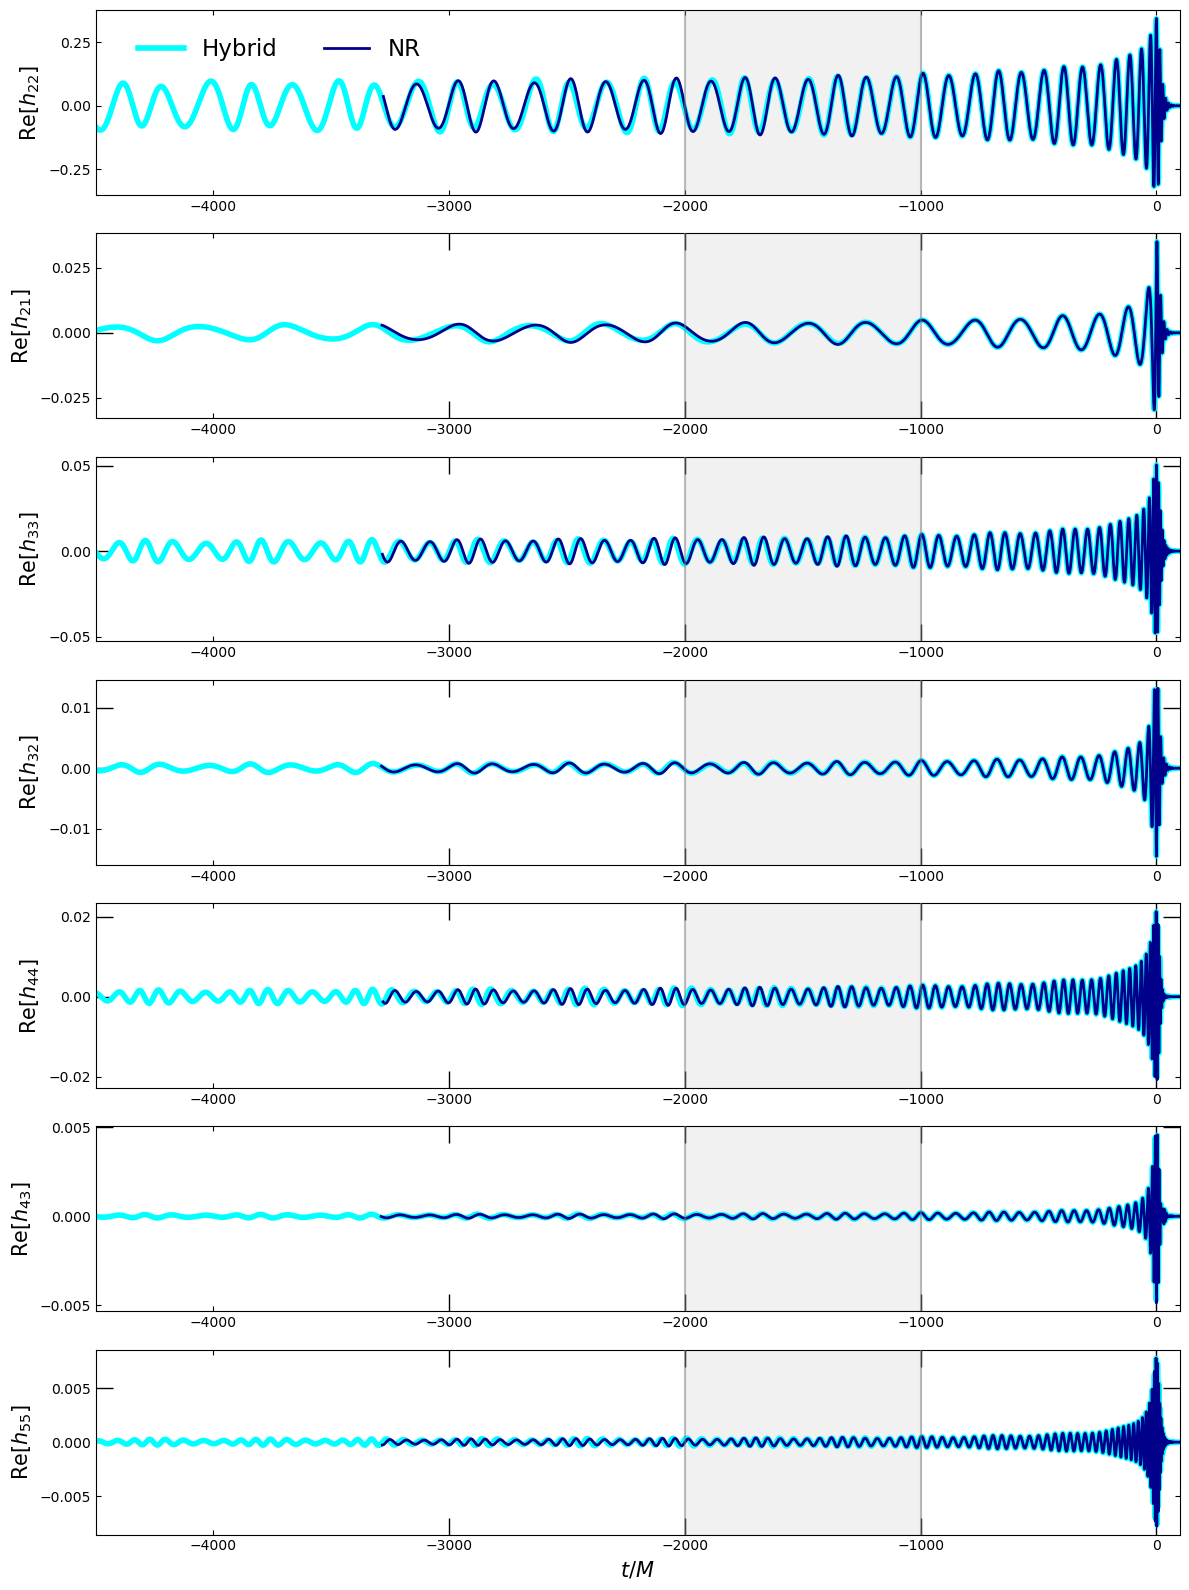

In [8]:
stackup_plots()

In [9]:
def strain_TT2_stackup():
    %run TaylorT2_Model.ipynb
    
    m = 30
    
    delta_t = 1./4096
    angle = 0
    d = 1
    k=0
    M_SI=m*MSUN_SI
    D_SI=(10**(6))*PC_SI
    mode2polfac=4*(5/(64*np.pi))**(1/2)

    hyb = ['1355','1356','1358','1359','1360','1361','1364','1365','1366','1367','1368','1372','1373']
    
    q0 = [1,1,1,1,1,1,2,2,2,2,2,3,3]

    l0 = [1.423,1.574,-2.682,1.834,-0.395,-1.019,-0.181,-1.127,-2.890,1.687,0.420,3.005,1.682]

    e0 = [0.173, 0.230, 0.322, 0.317, 0.416, 0.416, 0.172, 0.209, 0.320, 0.320, 0.324, 0.300, 0.300]

    f0 = [16.53, 15.63, 13.51, 13.92, 12.18, 11.95, 16.68, 15.72, 13.76, 13.84, 13.36, 13.75, 13.74]
    
    
    hp_T_dict = {}
    t_T_dict = {}
    hp_E_dict = {}
    t_E_dict = {}
    hp_NR_dict = {}
    t_NR_dict = {}
    
    for i in tqdm(range(len(q0))):
        
        #NR
        simulation = '/home/pratul/Downloads/Project/NR_data/'+hyb[i]+'_rhOverM_Asymptotic_GeometricUnits_CoM.h5'
        sims = simulation.split('_')[0]
        lp = 2 #modes
        mp = 2
        tref = 640  # Varies depending on simulations
        mode = 'l'+str(lp)+'_m'+str(mp)
        with h5py.File(simulation, 'r') as hdf:
            temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
            test=np.array(temp)

        x1=test[:,0]
        y1=test[:,1]    
        z1=test[:,2]


        plotband=np.where(x1>=tref)
        x1=x1[plotband]
        x1=x1-x1[np.argmax(abs(y1))]
        y1=y1[plotband]    
        z1=z1[plotband]
        
        x1 = x1-x1[np.argmax(abs(y1-1j*z1))]
        
        hp_T, _, t_T = TT2_MODEL22(m, q0[i], e0[i], l0[i], f0[i], angle, d, delta_t)
        hp_T_dict['hp_T{}'.format(i)] = hp_T
        t_T_dict['t_T{}'.format(i)] = t_T
    
        hp_E, _, t_E = Ecc_MODEL22(m, q0[i], e0[i], l0[i], f0[i], angle, d, delta_t)
        hp_E_dict['hp_E{}'.format(i)] = hp_E
        t_E_dict['t_E{}'.format(i)] = t_E
        
        hp_NR_dict['hp_NR{}'.format(i)] = y1
        t_NR_dict['t_NR{}'.format(i)] = x1
        
        
        
    #print(t_T_dict['t_T1'])
    plt.subplots(13,1,figsize=(12,26))
    for i in tqdm(range(len(q0))):
        plt.subplot(13, 1, i+1)
    
        plt.rc('xtick', labelsize=14) 
        plt.rc('ytick', labelsize=14) 
        mpl.rcParams['xtick.major.size'] = 12
        mpl.rcParams['xtick.major.width'] = 1
        mpl.rcParams['xtick.minor.size'] = 8
        mpl.rcParams['xtick.minor.width'] = 1
        mpl.rcParams['ytick.major.size'] = 12
        mpl.rcParams['ytick.major.width'] = 1
        mpl.rcParams['ytick.minor.size'] = 8
        mpl.rcParams['ytick.minor.width'] = 1
        plt.locator_params(axis='y',nbins=3)
        plt.tick_params(axis='y',direction='in',right=True)
        plt.tick_params(axis='x',direction='in',top=True)
    
        plt.plot(t_NR_dict['t_NR'+str(i)],hp_NR_dict['hp_NR'+str(i)]*mode2polfac,label='NR',color='navajowhite',linewidth=4.5)
        plt.plot(t_T_dict['t_T'+str(i)]/(m*MTSUN_SI),hp_T_dict['hp_T'+str(i)]/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),color='red',linewidth=2,label='TT2_model')
        plt.plot(t_E_dict['t_E'+str(i)]/(m*MTSUN_SI),hp_E_dict['hp_E'+str(i)]/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),label='EccTD_model',color='darkblue',linestyle='--',linewidth=2,alpha=0.6)
        plt.ylabel(r'$h_+$',fontsize=15)
        plt.xlim(-4500,100)
        plt.text(-3500, 0.12, 'q = '+str(q0[i]), color='black', fontsize=12)
        plt.text(-2500, 0.12, 'e = '+str(e0[i]), color='black', fontsize=12)
        plt.text(-1500,0.12, 'Sim = '+str(hyb[i]), color='black', fontsize=12)
        plt.xlabel(r'$t/M$',fontsize=15)
        
        colors = ['navajowhite', 'red', 'darkblue']
        boundaries = [-0.2, 0, 0.2]
        cmap = ListedColormap(colors)

        # Plot colorbar with custom colors
        cb = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=1)))
        cb.set_ticks([-0.5, 0, 0.5])
        cb.set_ticklabels(['NR', 'TT2', 'EccTD'])
        #cb.set_label('Intensity')
    
        plt.savefig('TT2_stackup.pdf',dpi=600)
    
    
        

100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  2.11it/s]


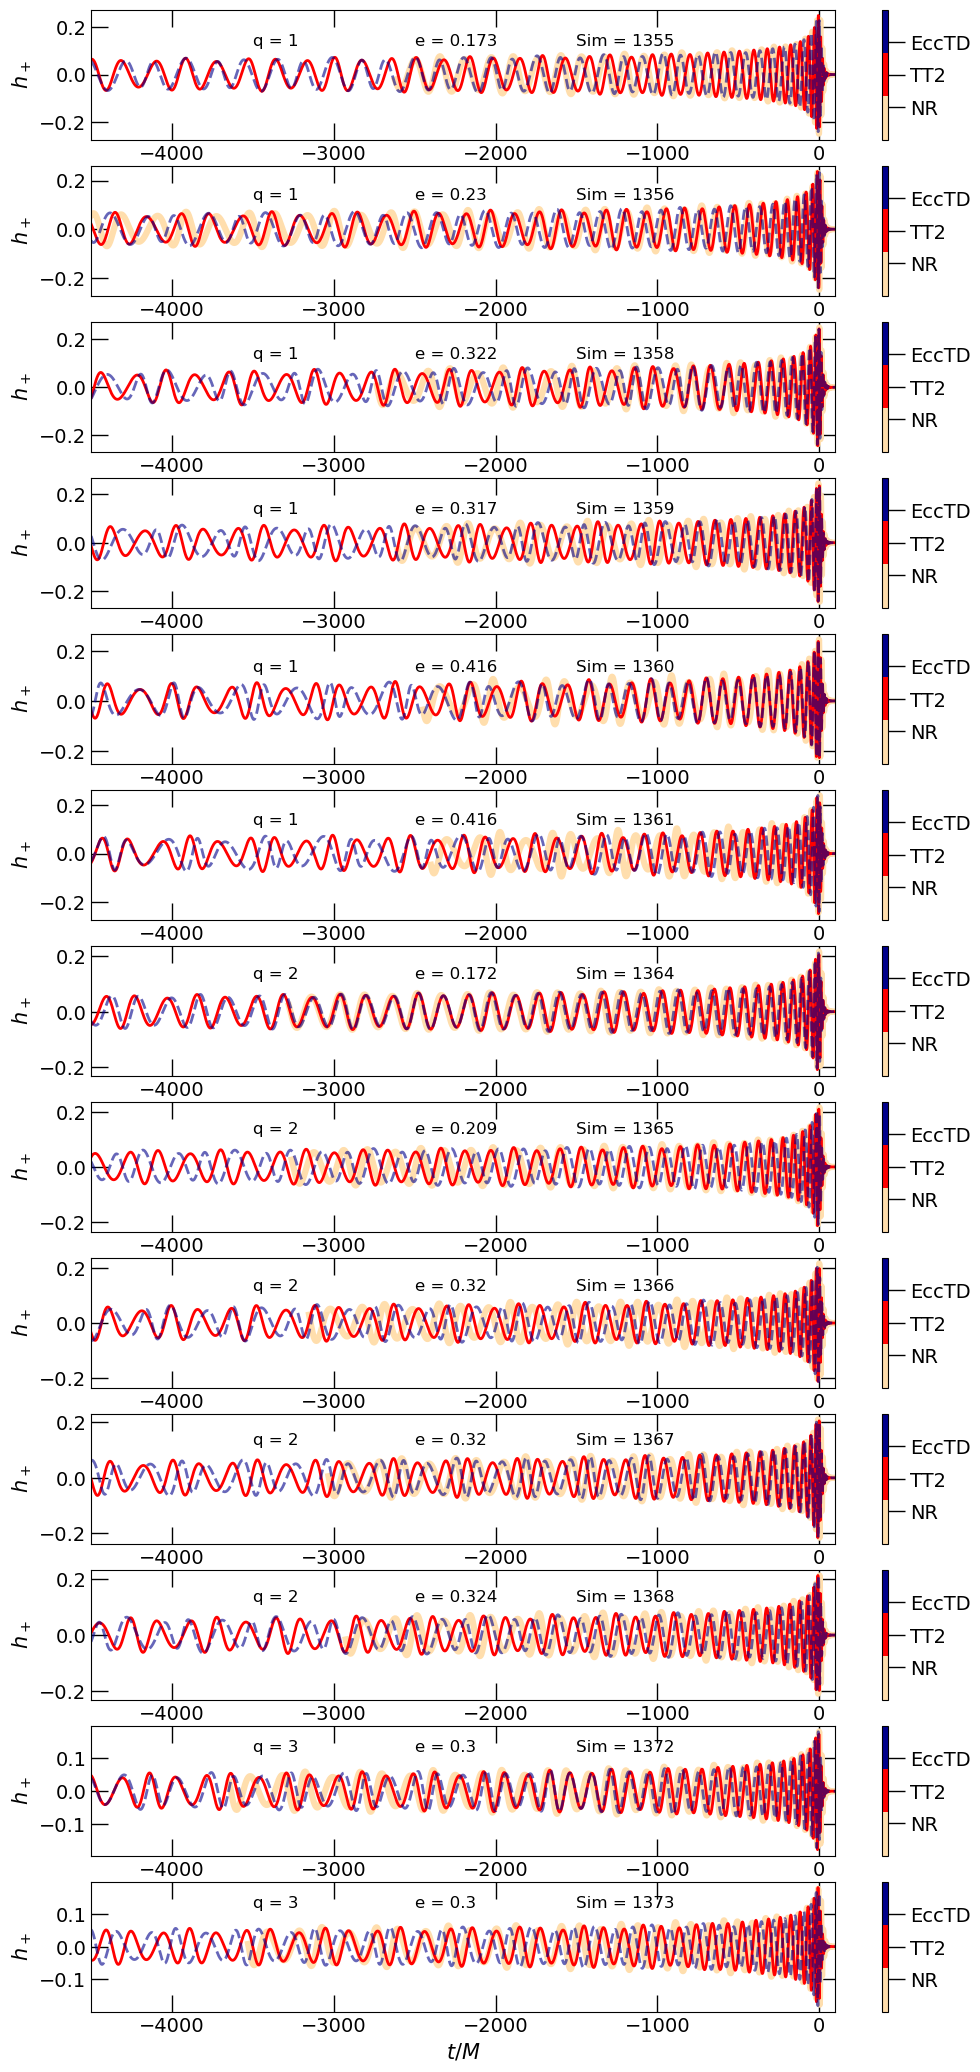

In [10]:
strain_TT2_stackup()